In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time

from skimage.feature import hog
from skimage import color, exposure
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from scipy.ndimage.measurements import label

#from sklearn.cross_validation import train_test_split

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

## Data Construction

In [2]:
cars_path = []
notcars_path = []
cars_path = cars_path + glob.glob('./data/vehicles/GTI_Far/*.png')
cars_path = cars_path + glob.glob('./data/vehicles/GTI_Left/*.png')
cars_path = cars_path + glob.glob('./data/vehicles/GTI_MiddleClose/*.png')
cars_path = cars_path + glob.glob('./data/vehicles/GTI_Right/*.png')
cars_path = cars_path + glob.glob('./data/vehicles/KITTI_extracted/*.png')

notcars_path = notcars_path + glob.glob('./data/non-vehicles/Extras/*.png')
notcars_path = notcars_path + glob.glob('./data/non-vehicles/GTI/*.png')
print(len(cars_path))
print(len(notcars_path))

8792
8968


## Data Exploration

Your function returned a count of 8792  cars and 8968  non-cars
of size:  (64, 64, 3)  and data type: float32
Display random 10 images from Car set


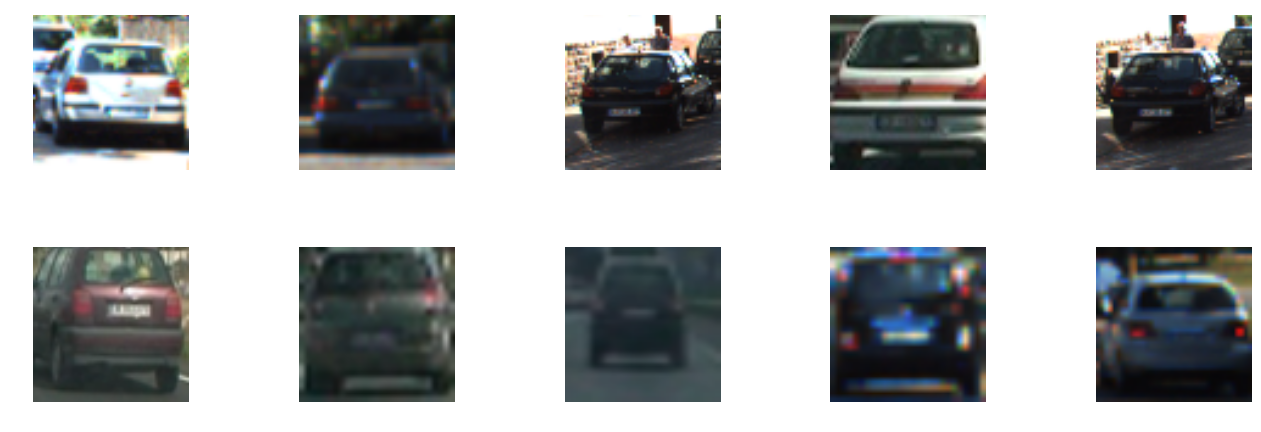

Display random 10 images that are not Cars


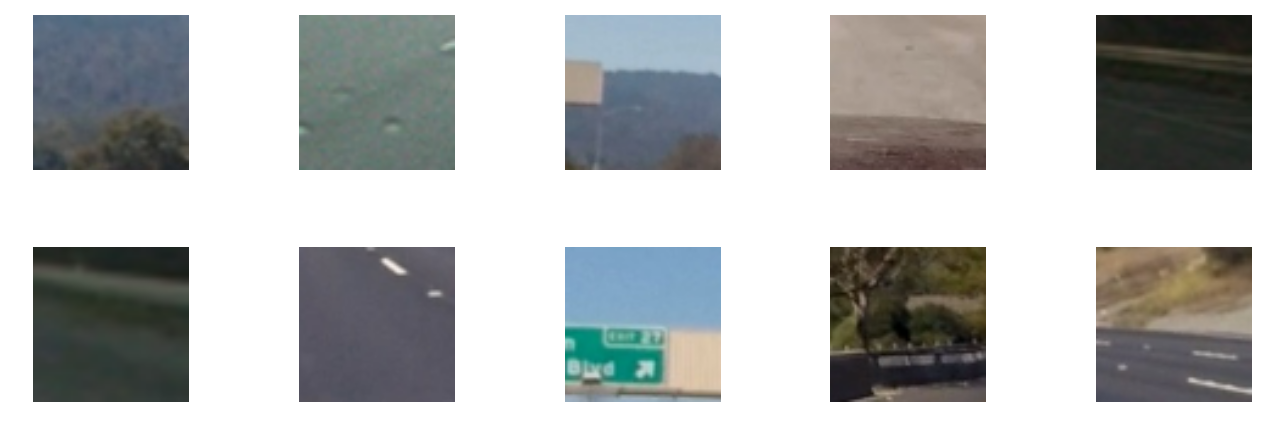

In [3]:
%matplotlib inline
#Code taken from class exercise
# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    example_img = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    # Return data_dict
    return data_dict
    
data_info = data_look(cars_path, notcars_path)

print('Your function returned a count of', data_info["n_cars"], ' cars and', data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', data_info["data_type"])

# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars_path))
notcar_ind = np.random.randint(0, len(notcars_path))

# Read in car / not-car images
car_image = cv2.imread(cars_path[8418])
notcar_image = cv2.imread(notcars_path[5362])

#Display random 10 car images
print("Display random 10 images from Car set")
ind = np.random.randint(len(cars_path), size=10)
fig, axes = plt.subplots(2,5,figsize=(16, 5),gridspec_kw={'wspace':0.5,'hspace':0.5})
axes.ravel()

i=0
for ax in axes.flat:
    i_train =  ind[i]
    car_image = cv2.imread(cars_path[i_train])
    ax.imshow(cv2.cvtColor(car_image,cv2.COLOR_BGR2RGB))
    ax.axis('off')
    i = i+1
plt.show()


#Display random 10 images that are not cars
print("Display random 10 images that are not Cars")
ind = np.random.randint(len(notcars_path), size=10)
fig, axes = plt.subplots(2,5,figsize=(16, 5),gridspec_kw={'wspace':0.5,'hspace':0.5})
axes.ravel()

i=0
for ax in axes.flat:
    i_train =  ind[i]
    notcar_image = cv2.imread(notcars_path[i_train])
    ax.imshow(cv2.cvtColor(notcar_image,cv2.COLOR_BGR2RGB))
    ax.axis('off')
    i = i+1
plt.show()


## Helper Functions for Building Feature List 

In [4]:
#Taken from course exercise
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True, vis=False):
    
    fig = plt.figure()
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        #image = mpimg.imread(file)
        image = cv2.imread(file)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        
        if vis:
            plt.imshow(image)
            plt.show()
         
        
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      
        
        feature_image = feature_image.astype(np.float32)/255
        
        
        if vis:
            plt.subplot(231)
            plt.axis('off')
            plt.imshow(feature_image[:,:,0],cmap='gray')
            plt.title('Channel 1')
            plt.subplot(232)
            plt.axis('off')
            plt.imshow(feature_image[:,:,1],cmap='gray')
            plt.title('Channel 2')
            plt.subplot(233)
            plt.axis('off')
            plt.imshow(feature_image[:,:,2],cmap='gray')
            plt.title('Channel 3')
        
        
        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                plot_ind = 234
                for channel in range(feature_image.shape[2]):
                    hog_features_single = get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True) 
                    if vis:
                        plt.subplot(plot_ind)
                        plt.axis('off')
                        plt.imshow(hog_image, cmap='gray')
                        plt.title('Hog feat')
                        plot_ind = plot_ind +1
                    hog_features.append(hog_features_single)
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        if vis:
            plt.show()
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features
    

## Feature Exploration

In [5]:
##: Tweak these parameters and see how the results change.
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = False # Spatial features on or off
hist_feat = False # Histogram features on or off
hog_feat = True # HOG features on or off


car_features = extract_features(cars_path, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars_path, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)
#scaled_X = X
# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


## Train a Classifier

In [6]:
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

Using: 11 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 6468
19.04 Seconds to train SVC...
Test Accuracy of SVC =  0.9842


## Helper Functions for Sliding Window Search

In [7]:
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

def convert_color(img, color_space='RGB'):
    if color_space != 'RGB':
        if color_space == 'HSV':
            return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: 
        return np.copy(img)      
    
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, 
              spatial_size, hist_bins, color_space='YUV', spatial_feat=True, hist_feat=True, hog_feat=True, show_all_rects=False):
    
    draw_img = np.copy(img)
    box_list = []
      
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, color_space)
    ctrans_tosearch = ctrans_tosearch.astype(np.float32)/255

    #print(ctrans_tosearch[1][1])
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
     
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    
    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            if(spatial_feat):
                spatial_features = bin_spatial(subimg, size=spatial_size)
            else:
                spatial_features =[]
            if(hist_feat):
                hist_features = color_hist(subimg, nbins=hist_bins)
            else:
                hist_features = []

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            #test_features = X_scaler.transform(hog_features.reshape(1, -1))
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1 or show_all_rects:
                #show_all_rects = False
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                box_list.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
    
    return draw_img, box_list

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [ ]:
# Define a class to store data from video
class Vehicle_Detect():
    def __init__(self):
        # history of rectangles previous n frames
        self.box_list = [] 
        
    def add_rects(self, rects):
        self.box_list.append(rects)
        if len(self.box_list) > 15:
            # throw out oldest rectangle set(s)
            self.box_list = self.box_list[len(self.box_list)-15:]


In [17]:
def process_frame(image, diag = False):

    box_list = []
    #fig = plt.figure()
    
    ystart = 400
    ystop = 650
    scale = 1

    out_img, temp_box_list = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, 
                    spatial_size, hist_bins, color_space= color_space, spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
    box_list = box_list + temp_box_list

    if diag: 
        plt.subplot(321)
        plt.imshow(out_img)
        plt.axis('off')
    
    ystart = 400
    ystop = 650
    scale = 1.5
    
    out_img,temp_box_list = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, 
                    spatial_size, hist_bins, color_space= color_space, spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

    box_list = box_list + temp_box_list

    if diag:
        plt.subplot(322)
        plt.imshow(out_img)
        plt.axis('off')
    
    ystart = 400
    ystop = 700
    scale = 2
    
    out_img, temp_box_list = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, 
                    spatial_size, hist_bins, color_space= color_space, spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

    box_list = box_list + temp_box_list

    if diag:
        plt.subplot(323)
        plt.imshow(out_img)
        plt.axis('off')
    
    
    ystart = 400
    ystop = 700
    scale = 3
    
    out_img, temp_box_list = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, 
                    spatial_size, hist_bins, color_space= color_space, spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

    box_list = box_list + temp_box_list

    if diag:
        plt.subplot(324)
        plt.imshow(out_img)
        plt.axis('off')
    
    ystart = 400
    ystop = 720
    scale = 4
    
    #out_img, temp_box_list = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, 
    #                spatial_size, hist_bins, color_space= color_space, spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

    #box_list = box_list + temp_box_list
    
    #if diag:
    #   plt.subplot(325)
    #   plt.imshow(out_img)
    #   plt.axis('off')
    #   plt.show()
    
    heatmap = np.zeros_like(image[:,:,0])
    heatmap1 = add_heat(heatmap, box_list)
    mul = 255// np.amax(heatmap1)
    heatmap_cpy1 = np.copy(mul * heatmap1)
    heatmap_cpy1[heatmap_cpy1 > 255] = 255
    diag_img = np.dstack((heatmap_cpy1, heatmap_cpy1, heatmap_cpy1))

    
    heatmap2 = apply_threshold(heatmap1,4)
    
    labels = label(heatmap2)
    result = draw_labeled_bboxes(np.copy(image), labels)    
        
    heatmap_cpy2 = np.copy(mul * heatmap2)
    heatmap_cpy2[heatmap_cpy2 > 255] = 255
    
    if diag:
        # Calculate the size of screens
        result_screen_w = result.shape[1]
        result_screen_h = result.shape[0]
        diag_screen_w = np.int(result_screen_w / 3)
        diag_screen_h = np.int(result_screen_h / 3)
        screen_w = result_screen_w + diag_screen_w
        screen_h = result_screen_h
        # Assign result image to the screen
        screen = np.zeros((screen_h, screen_w, 3), dtype=np.uint8)
        screen[0:result_screen_h, 0:result_screen_w] = result
        # Assgin diagnosis image to the screen
        diag_img_1 = image
        screen[0:diag_screen_h, result_screen_w:, :] = cv2.resize(diag_img_1, (diag_screen_w, diag_screen_h))
        diag_img_2 = np.dstack((heatmap_cpy2, heatmap_cpy2, heatmap_cpy2))
        screen[diag_screen_h : diag_screen_h*2, result_screen_w:, :] = cv2.resize(diag_img, (diag_screen_w, diag_screen_h))
        screen[diag_screen_h*2 : diag_screen_h*3, result_screen_w:, :] = cv2.resize(diag_img_2, (diag_screen_w, diag_screen_h))
        return screen
    else:
        return result
    

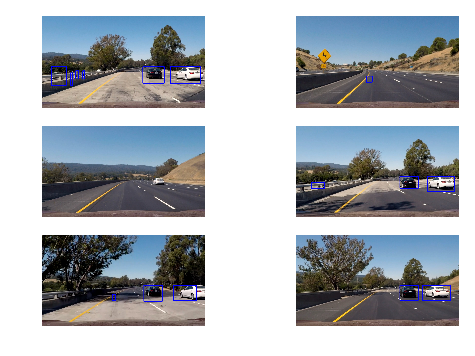

In [18]:
# Read all the test images
images_paths = glob.glob('./test_images/test*.jpg')
fig = plt.figure()
plt_ind = 321    
for path in images_paths:
    image = cv2.imread(path)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    result = process_frame(image)
    plt.subplot(plt_ind)
    plt.imshow(result)
    plt.axis('off')
    plt_ind = plt_ind + 1



In [19]:
#clip_test = VideoFileClip('test_videos/project_video.mp4').subclip(33,46)
test_out_file = 'test_videos_output/challenge_video.mp4'
clip_test = VideoFileClip('test_videos/challenge_video.mp4')
clip_test_out = clip_test.fl_image(process_frame)
%time clip_test_out.write_videofile(test_out_file, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge_video.mp4
[MoviePy] Writing video test_videos_output/challenge_video.mp4


100%|████████████████████████████████████████| 485/485 [05:51<00:00,  1.38it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge_video.mp4 

Wall time: 5min 52s
